# Clustering RGB image features with PhenoGraph

#### This notebook uses the matrix of 672 features per single cell RGB cropped image to cluster the cells and identify which are red blood cells based on clustering pattern

## Importing

In [1]:
import warnings
# To ignore Pandas Future Warning
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import scanpy as sc
import pandas as pd
from matplotlib import pyplot as plt
import phenograph
import copy
from scipy import sparse
from sklearn.metrics import adjusted_rand_score
import seaborn as sns
%matplotlib inline

In [2]:
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
print("phenograph==", phenograph.__version__)
sc.settings.set_figure_params(dpi=80, facecolor='white')

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.3 scipy==1.9.1 pandas==1.5.0 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.10.1 pynndescent==0.5.7
phenograph== 1.5.7


In [3]:
from os import listdir
from os.path import isfile, join

### Read in feature matrix as csv

In [4]:
pt = 'P57'

In [5]:
# read in features from each fov
feats_dir = 'Normalized_RGB_feats/'
tables = [f for f in listdir(feats_dir) if isfile(join(feats_dir, f))]
tables.sort()

In [6]:
# create all-fov feats table
all_fovs = pd.read_csv(feats_dir + tables[0], index_col=0)

for i in range(1,len(tables)):
    data = pd.read_csv(feats_dir + tables[i], index_col=0)
    all_fovs = pd.concat([all_fovs, data])
    
all_fovs

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,671
P57_FOV01_cell_1,0.403783,2.431730,3.104186,2.433941,0.569444,0.481490,2.258662,-0.145677,0.753173,0.347407,...,0.466433,0.342712,0.236676,0.068707,1.769199,0.181075,3.394268,-0.070038,0.621797,-0.047619
P57_FOV01_cell_2,0.439557,2.622461,3.049794,2.501937,0.577613,0.399747,2.274752,-0.152594,0.748144,0.344630,...,0.487329,-0.001973,0.179676,0.036392,1.771441,0.193269,3.447133,-0.077550,0.611068,-0.030814
P57_FOV01_cell_3,0.372967,2.471522,3.021076,2.450867,0.597075,0.446933,2.270688,-0.150941,0.741229,0.408235,...,0.495183,0.184635,0.204040,0.071913,1.776563,0.185092,3.473605,-0.095773,0.599817,-0.038240
P57_FOV01_cell_4,0.391306,2.555421,3.073325,2.530927,0.691152,0.401798,2.271097,-0.143148,0.771190,0.354342,...,0.504572,-0.002411,0.045929,0.036313,1.762392,0.289284,3.467737,-0.065374,0.587424,-0.004945
P57_FOV01_cell_5,0.400600,2.547995,3.156484,2.486411,0.577795,0.425067,2.292006,-0.157080,0.773753,0.437346,...,0.474268,0.027260,0.346432,0.026274,1.783514,0.170171,3.422363,-0.082033,0.572887,-0.038585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P57_FOV21_cell_3288,0.405655,2.727297,2.996825,2.713274,0.585623,0.374363,2.343380,-0.081402,0.859120,0.297240,...,0.522856,-0.048440,0.183048,-0.018182,1.740452,0.163066,3.412695,-0.053241,0.618105,-0.051032
P57_FOV21_cell_3289,0.383073,2.653415,3.076464,2.613322,0.699480,0.596774,2.303865,-0.077368,0.920783,0.334030,...,0.505330,-0.046297,0.169629,-0.001739,1.789966,0.163032,3.432247,-0.027757,0.539812,-0.016181
P57_FOV21_cell_3290,0.390456,2.717522,3.005869,2.614756,0.672407,0.542169,2.292055,0.008347,1.046064,0.330271,...,0.515206,-0.047622,0.249537,0.002170,1.795226,0.178625,3.371497,0.007624,0.511109,-0.004774
P57_FOV21_cell_3291,0.396858,2.740495,3.006277,2.707161,0.598167,0.389016,2.261179,-0.120909,0.843233,0.285772,...,0.522899,-0.053963,0.236837,-0.013968,1.747184,0.159031,3.453805,-0.040241,0.592279,-0.041493


In [7]:
# concatenate individual FOV feature tables as 1 large feature table
all_fovs.to_csv(pt + "_all_cell_RGB_features.csv", header=False)

In [8]:
# read in feature matrix as anndata object for clustering
adata = sc.read_csv(pt + "_all_cell_RGB_features.csv", first_column_names=True)
adata

AnnData object with n_obs × n_vars = 73866 × 672

In [9]:
adata.obs

""
P57_FOV01_cell_1
P57_FOV01_cell_2
P57_FOV01_cell_3
P57_FOV01_cell_4
P57_FOV01_cell_5
...
P57_FOV21_cell_3288
P57_FOV21_cell_3289
P57_FOV21_cell_3290
P57_FOV21_cell_3291


In [10]:
# load FOV metadata
FOV_metadata = pd.read_csv('/data/Zhaolab/1_AMLCosMx/Final_scripts/4_CellTyping/FOV_metadata.csv', index_col=0)
FOV_metadata

,Timepoint,Clinical outcome
P51_FOV01,A,PD
P51_FOV02,A,PD
P51_FOV03,A,PD
P51_FOV04,A,PD
P51_FOV05,A,PD
...,...,...
P58_FOV19,C,SD
P58_FOV20,C,SD
P58_FOV21,C,SD
P58_FOV22,C,SD


In [12]:
FOV_metadata.loc['P57_FOV13']

Timepoint            B
Clinical outcome    CR
Name: P57_FOV13, dtype: object

In [13]:
# add row for P57 FOV17 (missing from metadata table)
FOV_metadata.loc['P57_FOV17'] = ['C', 'CR']

In [14]:
# get FOV and cell number from cell ID

adata.obs['FOV'] = ''
adata.obs['cell_ID'] = 0
adata.obs['Timepoint'] = ''

for i in range(adata.obs.shape[0]):
    adata.obs['FOV'].iloc[i] = adata.obs.iloc[i].name[7:9]
    adata.obs['cell_ID'].iloc[i] = adata.obs.iloc[i].name[15:].replace('.png', '')
    adata.obs['Timepoint'].iloc[i] = FOV_metadata['Timepoint'].loc[adata.obs.iloc[i].name[0:9]]

adata.obs

/tmp/ipykernel_3004794/2228281499.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['FOV'].iloc[i] = adata.obs.iloc[i].name[7:9]
/tmp/ipykernel_3004794/2228281499.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['cell_ID'].iloc[i] = adata.obs.iloc[i].name[15:].replace('.png', '')


,FOV,cell_ID,Timepoint
P57_FOV01_cell_1,01,1,A
P57_FOV01_cell_2,01,2,A
P57_FOV01_cell_3,01,3,A
P57_FOV01_cell_4,01,4,A
P57_FOV01_cell_5,01,5,A
...,...,...,...
P57_FOV21_cell_3288,21,3288,C
P57_FOV21_cell_3289,21,3289,C
P57_FOV21_cell_3290,21,3290,C
P57_FOV21_cell_3291,21,3291,C


In [15]:
# save copy of complete anndata object
adata_all = adata

## Cluster Timepoint A FOVs for RBCs

In [16]:
tp = 'A'

In [17]:
# subset adata to just TPA
adata = adata_all[adata_all.obs['Timepoint'] == tp]
adata

View of AnnData object with n_obs × n_vars = 26490 × 672
    obs: 'FOV', 'cell_ID', 'Timepoint'

## Pre-Processing

### Log-Transformation

In [18]:
#Log-transform our dataset using the default Scanpy utility
adata_log1p = sc.pp.log1p(adata, copy = True)

### Principal Component Analysis (PCA)

In [19]:
#adata = adata_log1p # don't use log-scaled dataset
adata = sc.tl.pca(adata, n_comps = 50, copy = True)

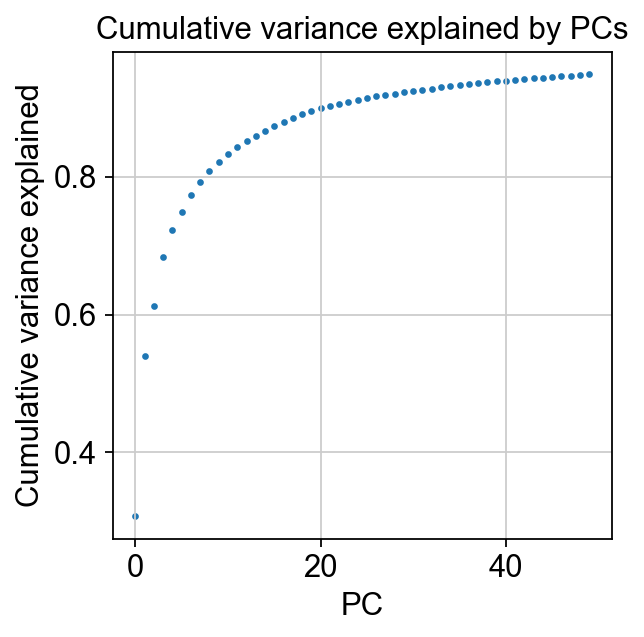

In [20]:
# Cumulative variance explained:
cml_var_explained = np.cumsum(adata.uns['pca']['variance_ratio'])
x = range(len(adata.uns['pca']['variance_ratio']))
y = cml_var_explained
plt.scatter(x, y, s=4)
plt.xlabel('PC')
plt.ylabel('Cumulative variance explained')
plt.title('Cumulative variance explained by PCs')
plt.show()

In [21]:
# set the minimum cumulative fraction of variance explained
min_cml_frac = 0.20
# find the number of PCs that together explain the minimal cum. fraction of variance
n_pcs = next(idx for idx,cml_frac in enumerate(cml_var_explained) if cml_frac > min_cml_frac)
print('Number of PCs that together explain a fraction of ' + str(min_cml_frac) + ' of the variance: ' + str(n_pcs))

Number of PCs that together explain a fraction of 0.2 of the variance: 0


## Clustering with PhenoGraph

### Running PhenoGraph

In [22]:
k = 15 # choose k, smaller values for finer-grained clustering
sc.settings.verbose = 0
communities, graph, Q = phenograph.cluster(pd.DataFrame(adata.obsm['X_pca']),k=k) # run PhenoGraph
# store the results in adata:
adata.obs['PhenoGraph_clusters'] = pd.Categorical(communities)
adata.uns['PhenoGraph_Q'] = Q
adata.uns['PhenoGraph_k'] = k

Finding 15 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 16.078150510787964 seconds
Jaccard graph constructed in 4.993975639343262 seconds
Wrote graph to binary file in 0.12471795082092285 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.789921
After 2 runs, maximum modularity is Q = 0.792314
Louvain completed 22 runs in 5.830402851104736 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 28.971773862838745 seconds


In [23]:
# run clustering
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
sc.tl.umap(adata)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


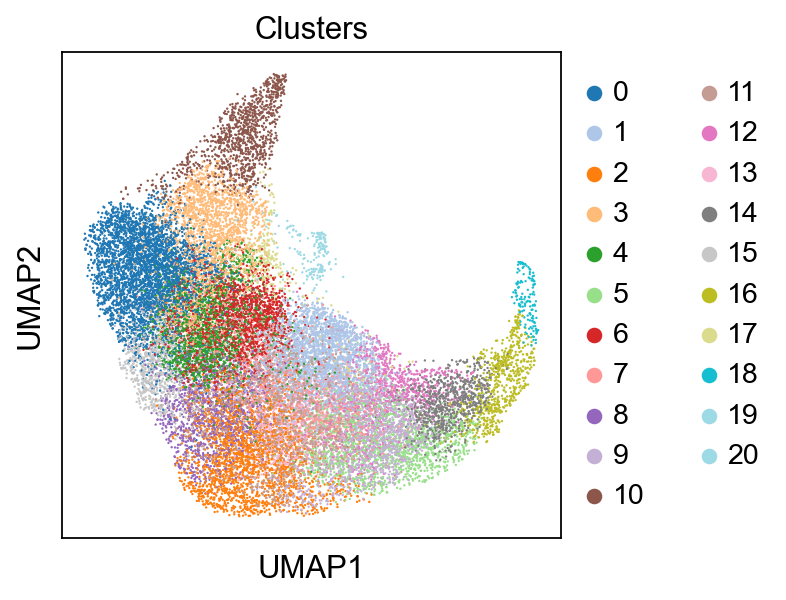

In [24]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"]
)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


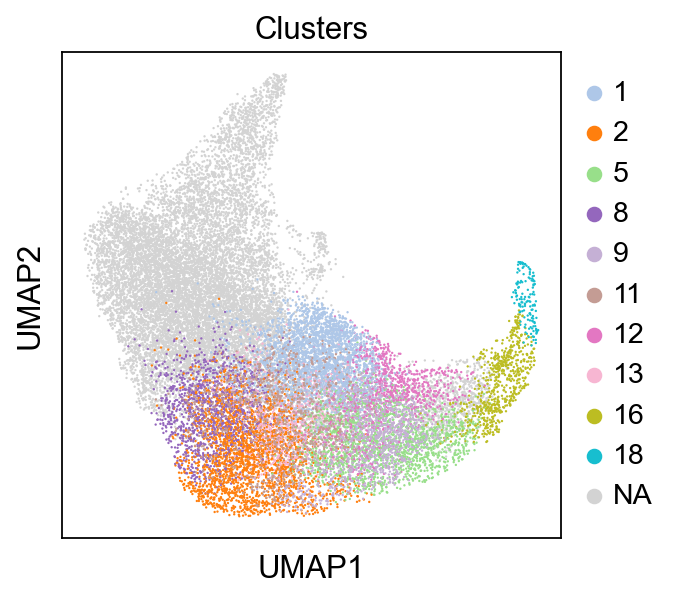

In [35]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"], groups=[1,2,5,8,9,11,12,13,16,18]
)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


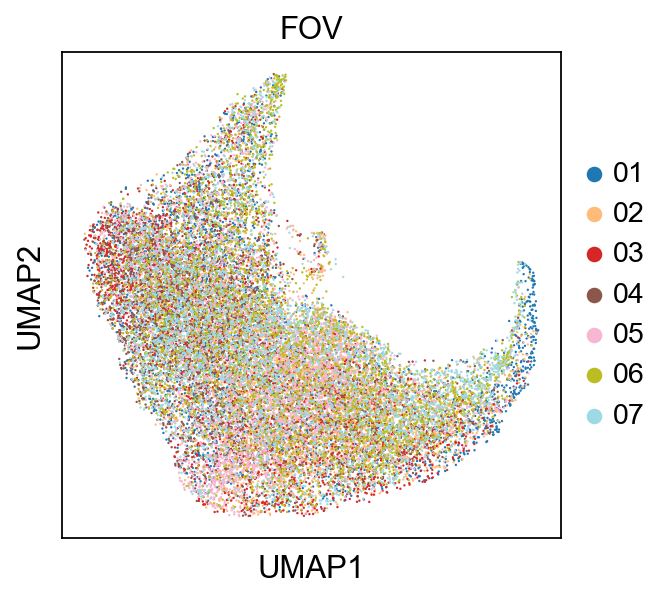

In [33]:
sc.pl.umap(
    adata, 
    color=['FOV'],
    palette='tab20', # 'palette' specifies the colormap to use)
    title=["FOV"]
)

In [27]:
# save dataframe of clustering results (adata.obs)
adata.obs.to_csv('TP' + tp + '/' + pt + tp + '_RGB_clusters.csv')

In [28]:
# save clustered data anndata object
adata_all.write_h5ad('TP' + tp + '/' + pt + tp + '_RGB_cell_features_clustered.h5ad')

## Cluster Timepoint B FOVs for RBCs

In [36]:
tp = 'B'

In [51]:
# subset adata to just TPA
adata = adata_all[adata_all.obs['Timepoint'] == tp]
adata

View of AnnData object with n_obs × n_vars = 29335 × 672
    obs: 'FOV', 'cell_ID', 'Timepoint'

## Pre-Processing

### Log-Transformation

In [52]:
#Log-transform our dataset using the default Scanpy utility
adata_log1p = sc.pp.log1p(adata, copy = True)

### Principal Component Analysis (PCA)

In [53]:
#adata = adata_log1p # don't use log-scaled dataset
adata = sc.tl.pca(adata, n_comps = 50, copy = True)

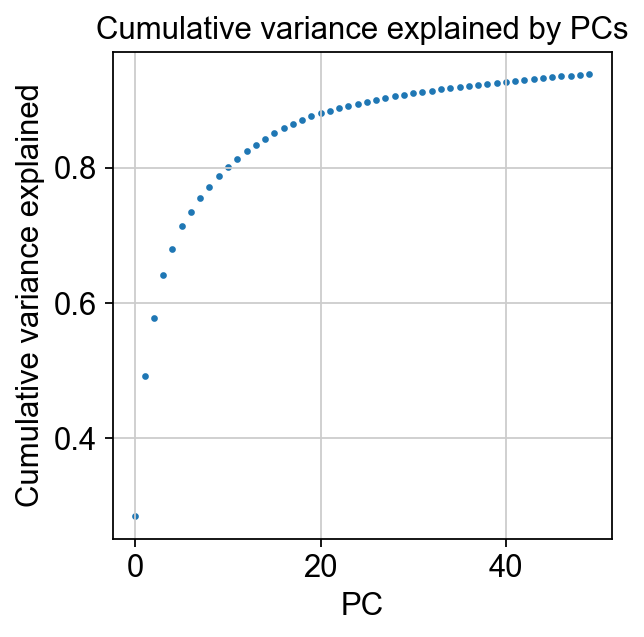

In [54]:
# Cumulative variance explained:
cml_var_explained = np.cumsum(adata.uns['pca']['variance_ratio'])
x = range(len(adata.uns['pca']['variance_ratio']))
y = cml_var_explained
plt.scatter(x, y, s=4)
plt.xlabel('PC')
plt.ylabel('Cumulative variance explained')
plt.title('Cumulative variance explained by PCs')
plt.show()

In [55]:
# set the minimum cumulative fraction of variance explained
min_cml_frac = 0.20
# find the number of PCs that together explain the minimal cum. fraction of variance
n_pcs = next(idx for idx,cml_frac in enumerate(cml_var_explained) if cml_frac > min_cml_frac)
print('Number of PCs that together explain a fraction of ' + str(min_cml_frac) + ' of the variance: ' + str(n_pcs))

Number of PCs that together explain a fraction of 0.2 of the variance: 0


## Clustering with PhenoGraph

### Running PhenoGraph

In [56]:
k = 10 # choose k, smaller values for finer-grained clustering
sc.settings.verbose = 0
communities, graph, Q = phenograph.cluster(pd.DataFrame(adata.obsm['X_pca']),k=k) # run PhenoGraph
# store the results in adata:
adata.obs['PhenoGraph_clusters'] = pd.Categorical(communities)
adata.uns['PhenoGraph_Q'] = Q
adata.uns['PhenoGraph_k'] = k

Finding 10 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 20.490291357040405 seconds
Jaccard graph constructed in 4.593269348144531 seconds
Wrote graph to binary file in 0.08457446098327637 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.80304
After 6 runs, maximum modularity is Q = 0.804308
Louvain completed 26 runs in 5.4418299198150635 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 33.049811601638794 seconds


In [57]:
# run clustering
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
sc.tl.umap(adata)

In [58]:
# read in clustered df
#adata = sc.read_h5ad("P56" + tp + "_RGB_cell_features_clustered.h5ad")
#adata

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


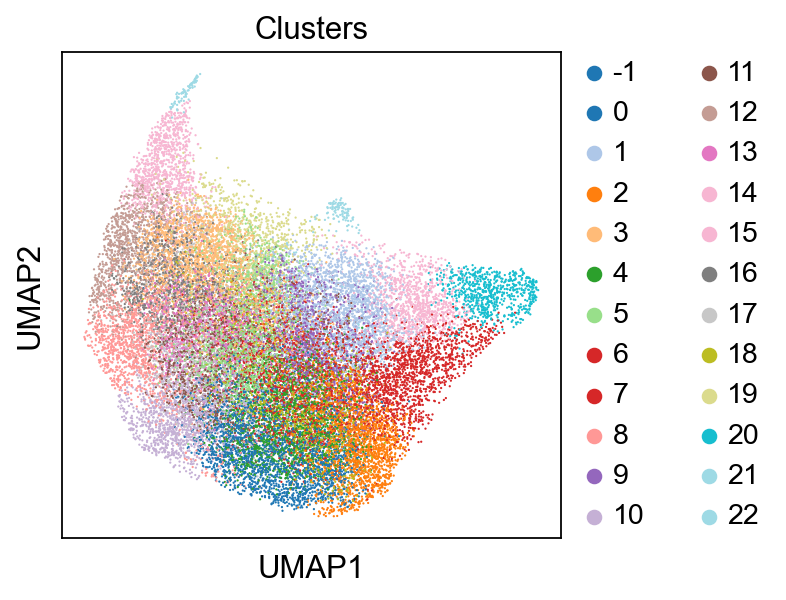

In [59]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"]
)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


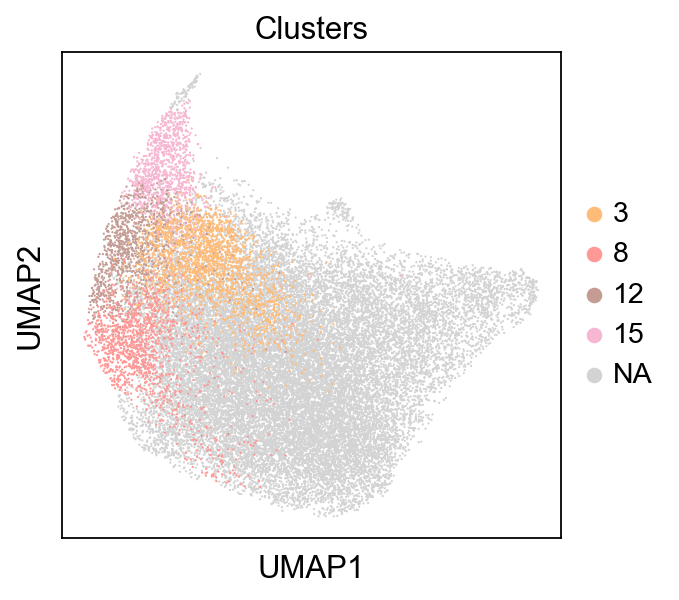

In [64]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"], groups=[3,8,12,15]
)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


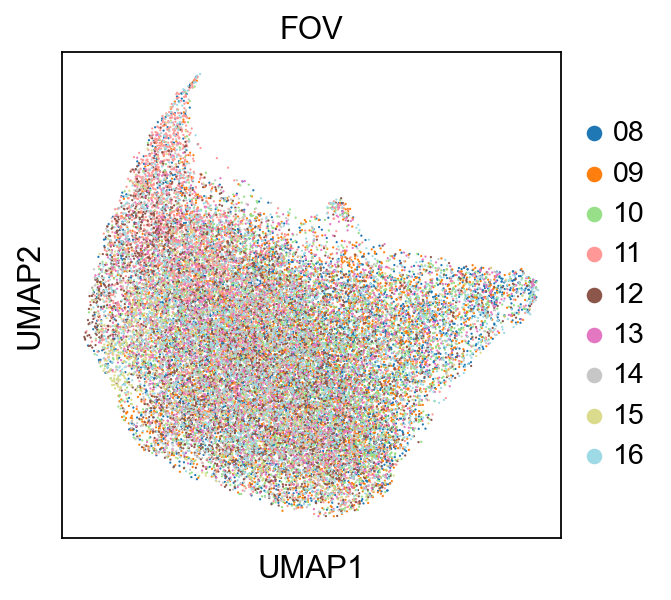

In [61]:
sc.pl.umap(
    adata, 
    color=['FOV'],
    palette='tab20', # 'palette' specifies the colormap to use)
    title=["FOV"]
)

In [62]:
# save dataframe of clustering results (adata.obs)
adata.obs.to_csv('TP' + tp + '/' + pt + tp + '_RGB_clusters.csv')

In [63]:
# save clustered data anndata object
adata_all.write_h5ad('TP' + tp + '/' + pt + tp + '_RGB_cell_features_clustered.h5ad')

## Cluster Timepoint C FOVs for RBCs

In [65]:
tp = 'C'

In [66]:
# subset adata to just TPA
adata = adata_all[adata_all.obs['Timepoint'] == tp]
adata

View of AnnData object with n_obs × n_vars = 18041 × 672
    obs: 'FOV', 'cell_ID', 'Timepoint'

## Pre-Processing

### Log-Transformation

In [67]:
#Log-transform our dataset using the default Scanpy utility
adata_log1p = sc.pp.log1p(adata, copy = True)

### Principal Component Analysis (PCA)

In [68]:
#adata = adata_log1p # don't use log-scaled dataset
adata = sc.tl.pca(adata, n_comps = 50, copy = True)

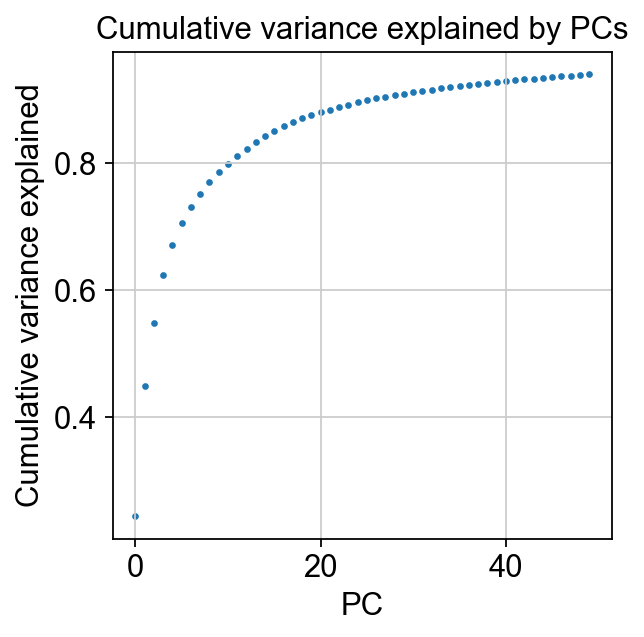

In [69]:
# Cumulative variance explained:
cml_var_explained = np.cumsum(adata.uns['pca']['variance_ratio'])
x = range(len(adata.uns['pca']['variance_ratio']))
y = cml_var_explained
plt.scatter(x, y, s=4)
plt.xlabel('PC')
plt.ylabel('Cumulative variance explained')
plt.title('Cumulative variance explained by PCs')
plt.show()

In [70]:
# set the minimum cumulative fraction of variance explained
min_cml_frac = 0.20
# find the number of PCs that together explain the minimal cum. fraction of variance
n_pcs = next(idx for idx,cml_frac in enumerate(cml_var_explained) if cml_frac > min_cml_frac)
print('Number of PCs that together explain a fraction of ' + str(min_cml_frac) + ' of the variance: ' + str(n_pcs))

Number of PCs that together explain a fraction of 0.2 of the variance: 0


## Clustering with PhenoGraph

### Running PhenoGraph

In [71]:
k = 10 # choose k, smaller values for finer-grained clustering
sc.settings.verbose = 0
communities, graph, Q = phenograph.cluster(pd.DataFrame(adata.obsm['X_pca']),k=k) # run PhenoGraph
# store the results in adata:
adata.obs['PhenoGraph_clusters'] = pd.Categorical(communities)
adata.uns['PhenoGraph_Q'] = Q
adata.uns['PhenoGraph_k'] = k

Finding 10 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 7.421475172042847 seconds
Jaccard graph constructed in 3.9650418758392334 seconds
Wrote graph to binary file in 0.05781698226928711 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.807401
After 12 runs, maximum modularity is Q = 0.808854
Louvain completed 32 runs in 3.8246195316314697 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 17.67407536506653 seconds


In [72]:
# run clustering
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
sc.tl.umap(adata)

In [73]:
# read in clustered df
#adata = sc.read_h5ad("P56" + tp + "_RGB_cell_features_clustered.h5ad")
#adata

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


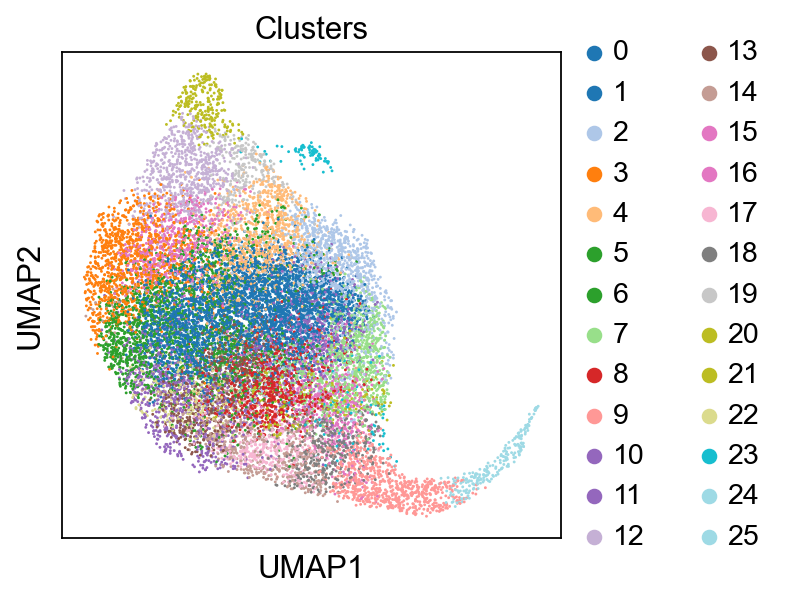

In [74]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"]
)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


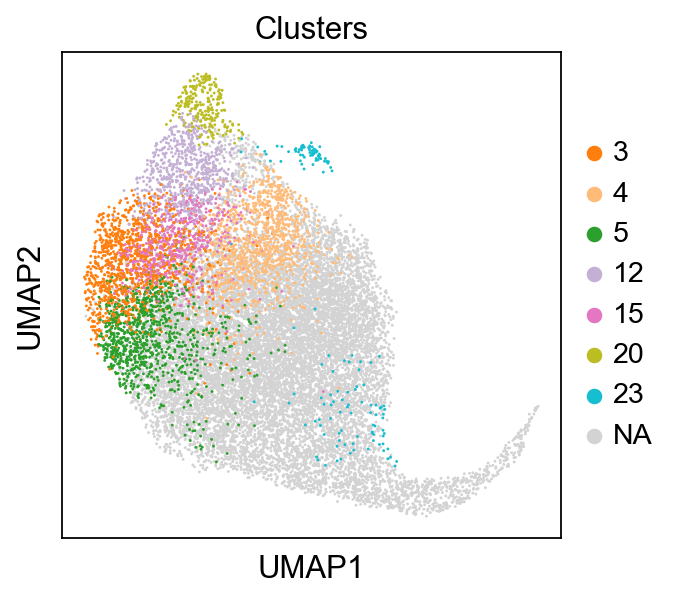

In [96]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"], groups=[3,4,5,12,15,20,23]
)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


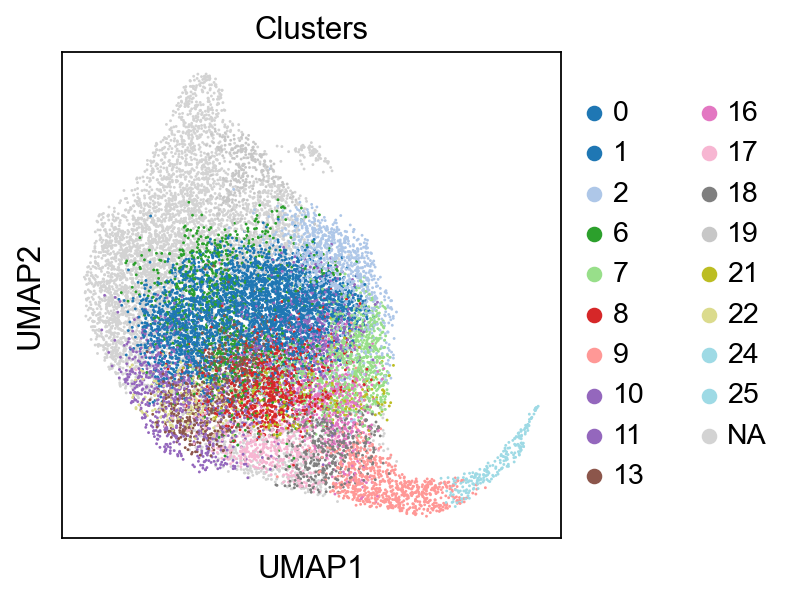

In [97]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"], groups=[0,1,2,6,7,8,9,10,11,13,16,17,18,19,21,22,24,25]
)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


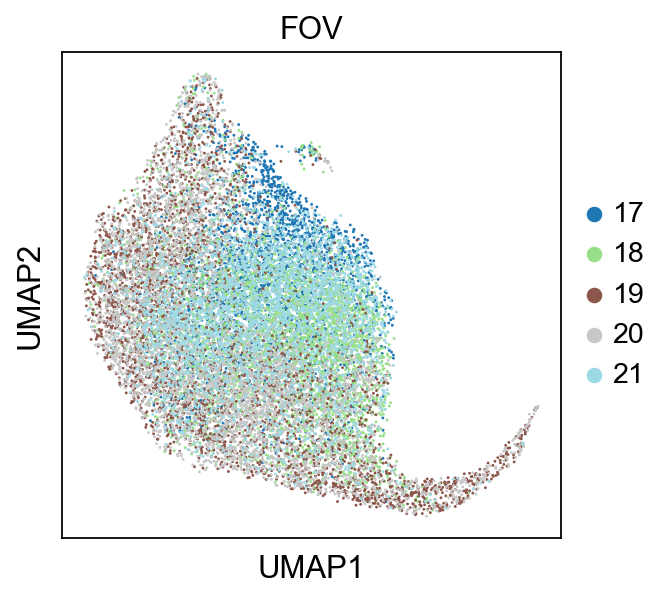

In [93]:
sc.pl.umap(
    adata, 
    color=['FOV'],
    palette='tab20', # 'palette' specifies the colormap to use)
    title=["FOV"]
)

In [94]:
# save dataframe of clustering results (adata.obs)
adata.obs.to_csv('TP' + tp + '/' + pt + tp + '_RGB_clusters.csv')

In [95]:
# save clustered data anndata object
adata_all.write_h5ad('TP' + tp + '/' + pt + tp + '_RGB_cell_features_clustered.h5ad')